In [1]:
import os, sys, rdflib
import numpy as np, pandas as pd
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import rdflib.plugins.sparql as sparql
from SPARQLWrapper import SPARQLWrapper, JSON
sys.path.append(os.path.abspath("./util"))
from misc import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import metrics
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering

In [2]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    dbpedia_type_graph = rdflib.Graph()
    dbpedia_type_graph.parse('./dataset/instance_types_en_uris_it.nt', format="nt" )
    dbpedia_type_graph.parse('./dataset/instance_types_en.nt', format="nt" )

CPU times: user 44.6 ms, sys: 11.6 ms, total: 56.2 ms
Wall time: 56.8 ms


In [3]:
%%time
# mapping freebase's mids to dbpedia's resources
mid2dbpedia = dict()
file_path = "./dataset/Release/freebase_code_names.txt"
with open(file_path, "r") as mapping_file:
    for line in mapping_file:
        mid, dbp_resource = line.replace("\n", "").split("\t")
        val = mid2dbpedia.get(mid, [])
        mid2dbpedia[mid] = val + [dbp_resource]

CPU times: user 311 ms, sys: 13.1 ms, total: 324 ms
Wall time: 357 ms


In [4]:
walks_path = "./dataset/Release/ttl/embedding_5_7_train.ttl.txt"

vocab_sequences = get_sequences(walks_path)
train_sequences = get_sequences(walks_path)

model = Word2Vec(min_count=1, window=5, negative=5, size=100, sg=1)

model.build_vocab(vocab_sequences)
model.train(train_sequences)

418031

In [5]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    mid2types = dict()
    for uri in model.vocab:
        mid = uri.replace("http://rdf.freebase.com/ns", "")
        if mid in mid2dbpedia:
            dbpedia_eqs = [uri[1:-1] for uri in mid2dbpedia[mid]]
            mid_types = {row[0].n3() for uri in dbpedia_eqs for row in get_types(uri, dbpedia_type_graph)}
            if len(mid_types) > 0:
                mid2types[mid] = mid_types
    %store mid2types

CPU times: user 346 µs, sys: 56 µs, total: 402 µs
Wall time: 370 µs


In [6]:
%%time
mid_prefix = "http://rdf.freebase.com/ns"

embeds = np.asarray([model[mid_prefix + mid] for mid in mid2types if mid_prefix + mid in model])
mids   = np.asarray([mid for mid in mid2types])
labels = np.asarray([1 if is_person(mid, mid2types) else 0 for mid in mid2types])

tsne = TSNE(n_components=2)
%store -r twodims
if "twodims" not in locals():
    twodims = tsne.fit_transform(embeds)
    %store twodims

ground_truth = get_ground_truth(mids, mid2types)

colors  = [get_color(i) for i in ground_truth]

CPU times: user 99.8 ms, sys: 7.17 ms, total: 107 ms
Wall time: 119 ms


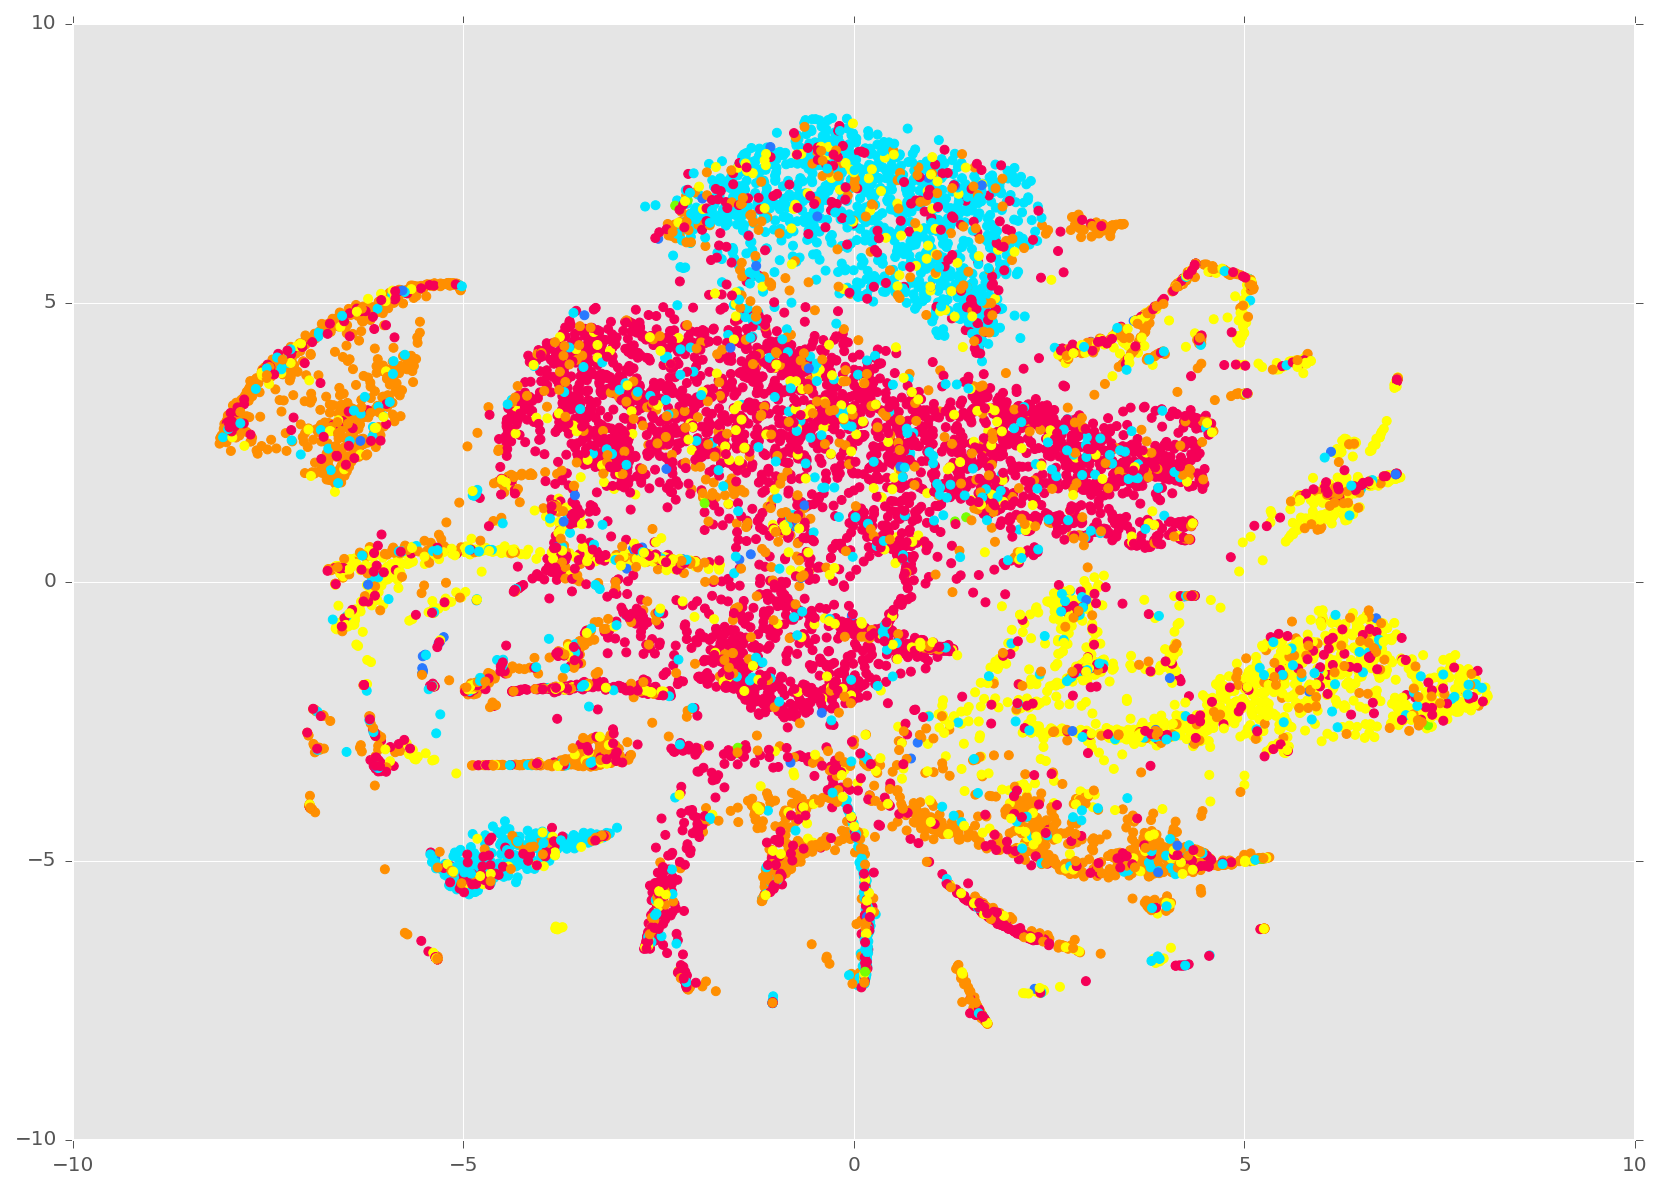

In [7]:
fig_size = [14, 10]
plt.rcParams["figure.figsize"] = fig_size
x = [point[0] for point in twodims]
y = [point[1] for point in twodims]
plt.scatter(x, y, color=colors)
plt.show()

In [8]:
%%time
hdbscan = HDBSCAN(min_cluster_size=30)
dbscan  = DBSCAN(eps=0.4, min_samples=5)
kmeans  = KMeans(n_clusters=10)
spect   = SpectralClustering(n_clusters=7, eigen_solver='arpack', affinity="nearest_neighbors")
aggl    = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=7)

hdbscan_labels = hdbscan.fit_predict(embeds.astype(np.double))
dbscan_labels  = dbscan.fit_predict(embeds.astype(np.double))
kmeans_labels  = kmeans.fit_predict(embeds.astype(np.double))
%store -r spect_labels
%store -r aggl_labels

if "spect_labels" not in locals():
    spect_labels = spect.fit_predict(embeds.astype(np.double))
    aggl_labels  = aggl.fit_predict(embeds.astype(np.double))
    %store spect_labels
    %store aggl_labels

cluster_colors = [get_color(clust) for clust in spect_labels]

CPU times: user 1min 12s, sys: 985 ms, total: 1min 13s
Wall time: 1min 10s


In [18]:
cluster_colors = [get_color(clust) for clust in spect_labels]

In [11]:
metrics_class_df = pd.concat([
    # clust_metrics(ground_truth[:-1], hdbscan_labels, embeds, metric="euclidean", name="HDBSCAN"),
    clust_metrics(ground_truth, dbscan_labels, embeds, metric="euclidean", name="DBSCAN"),
    clust_metrics(ground_truth, kmeans_labels, embeds, metric="euclidean", name="KMeans"),
    clust_metrics(ground_truth, spect_labels, embeds, metric="euclidean", name="Spectral"),
    clust_metrics(ground_truth, aggl_labels, embeds, metric="euclidean", name="Agglomerative")
])

metrics_class_df

,Homogeneity,Completeness,V-Measure score,Adjusted Rand index,Mutual Information,Silhouette
DBSCAN,0.012680,0.185138,0.023734,0.007639,0.012296,0.643485
KMeans,0.354985,0.261584,0.301210,0.195248,0.260861,0.229451
Spectral,0.195493,0.218288,0.206263,0.121244,0.194775,0.090845
Agglomerative,0.000601,0.143566,0.001197,0.000114,0.000091,0.790993


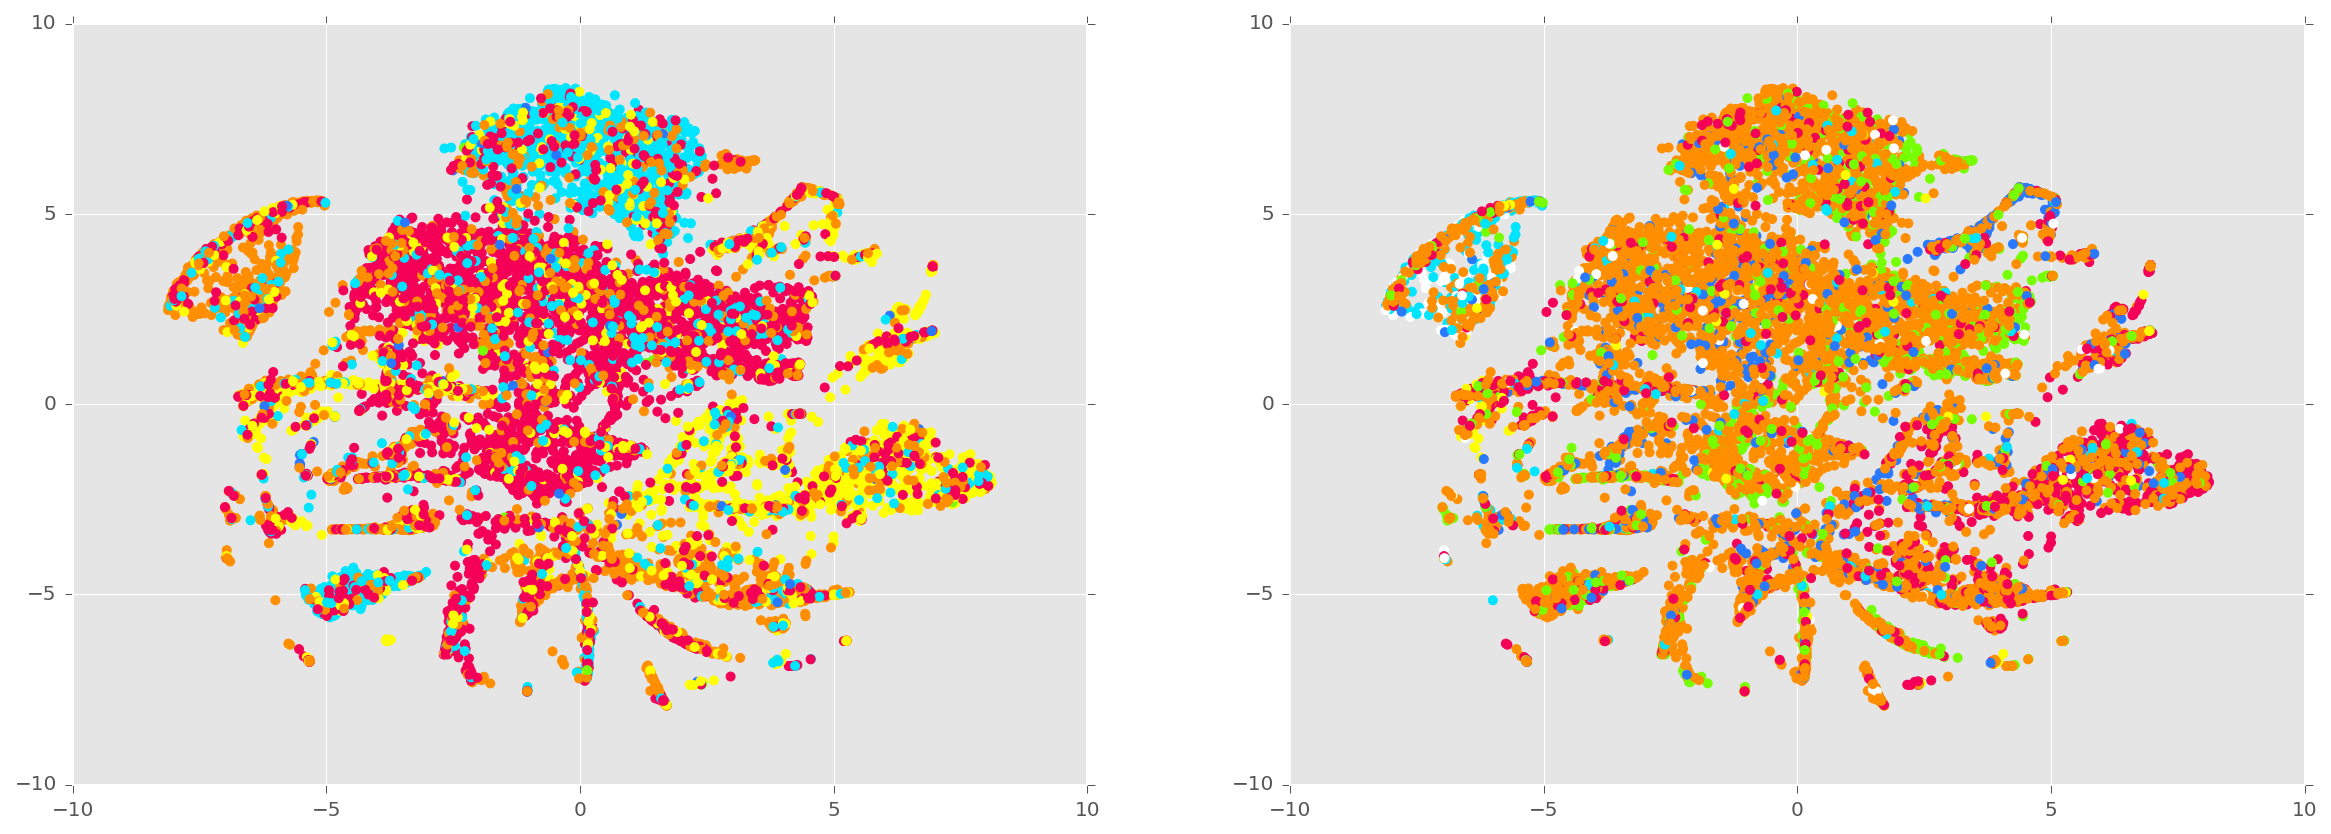

In [19]:
plt.rcParams["figure.figsize"] = [20, 15]

fig, ax = plt.subplots(nrows=1, ncols=2)
plt.subplot(2, 2, 1)
plt.scatter(x, y, color=colors)

plt.subplot(2, 2, 2)
plt.scatter(x, y, color=cluster_colors)
plt.show()